# Тема: Класифiкацiя кольорових зображень з використанням згорткових нейронних мереж в TensorFlow. Технологiя передачi знань (transfer learning)

### Варіант 20
Хiд виконання роботи
1. Завантажити набiр даних iз зображеннями згiдно з варiантом.
2. Пiдготувати данi для навчання - за необхiдностi.
3. Побудувати i навчити базову згорткову модель з одним згортковим шаром.
4. Побудувати i навчити кiлька розширених згорткових моделей, якi включають
шари дропауту i нормалiзацiї за мiнi-батчами.

5. Дослiдити чи впливає на результат змiна параметрiв padding i strides згор ткового шару, а також розмiрнiсть ядра (kernel) згортки. 

6. Для базової i усiх розширених моделей побудувати:

- графiки змiни функцiї втрат (loss) на тренувальнiй i перевiрочнiй множинах
по мiрi навчання моделей,

- графiки змiни точностi (accuracy) на тренувальнiй i перевiрочнiй множинах
по мiрi навчання моделей.

7. Вiдобразити у TensorBoard графiки, якi iлюструють оцiнки якостi навчання
мережi на навчальнiй та перевiрочнiй множинах.
8. Зробити висновки щодо якостi навчання мережi:

- з i без використання дропаута i нормалiзацiї за мiнi-батчами,

- при використаннi рiзних значень параметрiв padding i strides згорткового
шару,

- при використаннi рiзних значень розмiрностi ядра згортки.
9. Побудувати ще одну модель на базi попередньо навченої VGG16, Inception,
Exception чи iншої (на вибiр), використовуючи технологiю передачi знань (transfer
learning).

10. Завантажити зображення тестової множни i розпiзнати його навченими моделями.

**Варіант 20**:

`The Simpsons Characters Data, kaggle.com`

# Setup environment

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import datetime

from IPython.display import clear_output

# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#     print('GPU device not found')
# print('Found GPU at: {}'.format(device_name))
# tf.config.threading.set_intra_op_parallelism_threads(0)

# from tensorflow.keras import Sequential, Input, initializers, optimizers, callbacks

# from tensorflow.keras import Model, regularizers
# from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten, ReLU, PReLU
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPool2D, MaxPooling2D

from keras.applications import VGG16, InceptionV3
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

# from tensorflow.keras.metrics import Accuracy, AUC
# from tensorflow.keras.metrics import Precision, Recall
# from tensorflow.keras.losses import CategoricalCrossentropy

# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.callbacks import TensorBoard
# %load_ext tensorboard
# import tensorflow_addons as tfa

# from tensorflow_addons.metrics import F1Score

from skimage.transform import resize
from skimage.io import imread

SEED = 413

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Load Data

In [2]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [3]:
# Create a list with the filepaths
train_dir = Path('../input/the-simpsons-characters-dataset/simpsons_dataset')
filepaths = list(train_dir.glob(r'**/*.jpg'))

# Create a DataFrame with the filepaths and the labels of the picture
df = proc_img(filepaths)

print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

# The DataFrame with the filepaths in one column and the labels in the other one
df.head(5)

Number of pictures: 41866

Number of different labels: 42

Labels: ['groundskeeper_willie' 'lisa_simpson' 'milhouse_van_houten'
 'krusty_the_clown' 'selma_bouvier' 'marge_simpson' 'sideshow_bob'
 'moe_szyslak' 'cletus_spuckler' 'apu_nahasapeemapetilon' 'bart_simpson'
 'homer_simpson' 'ned_flanders' 'professor_john_frink' 'principal_skinner'
 'martin_prince' 'chief_wiggum' 'charles_montgomery_burns'
 'edna_krabappel' 'comic_book_guy' 'lenny_leonard'
 'abraham_grampa_simpson' 'kent_brockman' 'nelson_muntz' 'carl_carlson'
 'rainier_wolfcastle' 'sideshow_mel' 'patty_bouvier' 'waylon_smithers'
 'maggie_simpson' 'ralph_wiggum' 'mayor_quimby' 'fat_tony' 'otto_mann'
 'snake_jailbird' 'agnes_skinner' 'lionel_hutz' 'barney_gumble'
 'disco_stu' 'miss_hoover' 'gil' 'troy_mcclure']


Filepath                 Label
0  ../input/the-simpsons-characters-dataset/simps...  groundskeeper_willie
1  ../input/the-simpsons-characters-dataset/simps...          lisa_simpson
2  ../input/the-simpsons-characters-dataset/simps...   milhouse_van_houten
3  ../input/the-simpsons-characters-dataset/simps...      krusty_the_clown
4  ../input/the-simpsons-characters-dataset/simps...         selma_bouvier

In [4]:
df = df.sample(10000) #

In [5]:
df = df[~df['Label'].isin(['troy_mcclure', 'lionel_hutz', 'disco_stu', 'miss_hoover', 'gil', 'otto_mann'])]
df = df.reset_index(drop=True)

In [24]:
df['Label'].value_counts()

homer_simpson               1025
moe_szyslak                  725
ned_flanders                 695
bart_simpson                 692
marge_simpson                645
lisa_simpson                 640
charles_montgomery_burns     591
principal_skinner            566
krusty_the_clown             561
milhouse_van_houten          490
chief_wiggum                 487
abraham_grampa_simpson       437
sideshow_bob                 418
apu_nahasapeemapetilon       283
kent_brockman                244
comic_book_guy               218
edna_krabappel               217
nelson_muntz                 174
lenny_leonard                152
mayor_quimby                 112
waylon_smithers               86
barney_gumble                 58
groundskeeper_willie          55
maggie_simpson                50
selma_bouvier                 49
carl_carlson                  44
ralph_wiggum                  42
patty_bouvier                 31
martin_prince                 31
professor_john_frink          29
snake_jail

### Visualize pictures

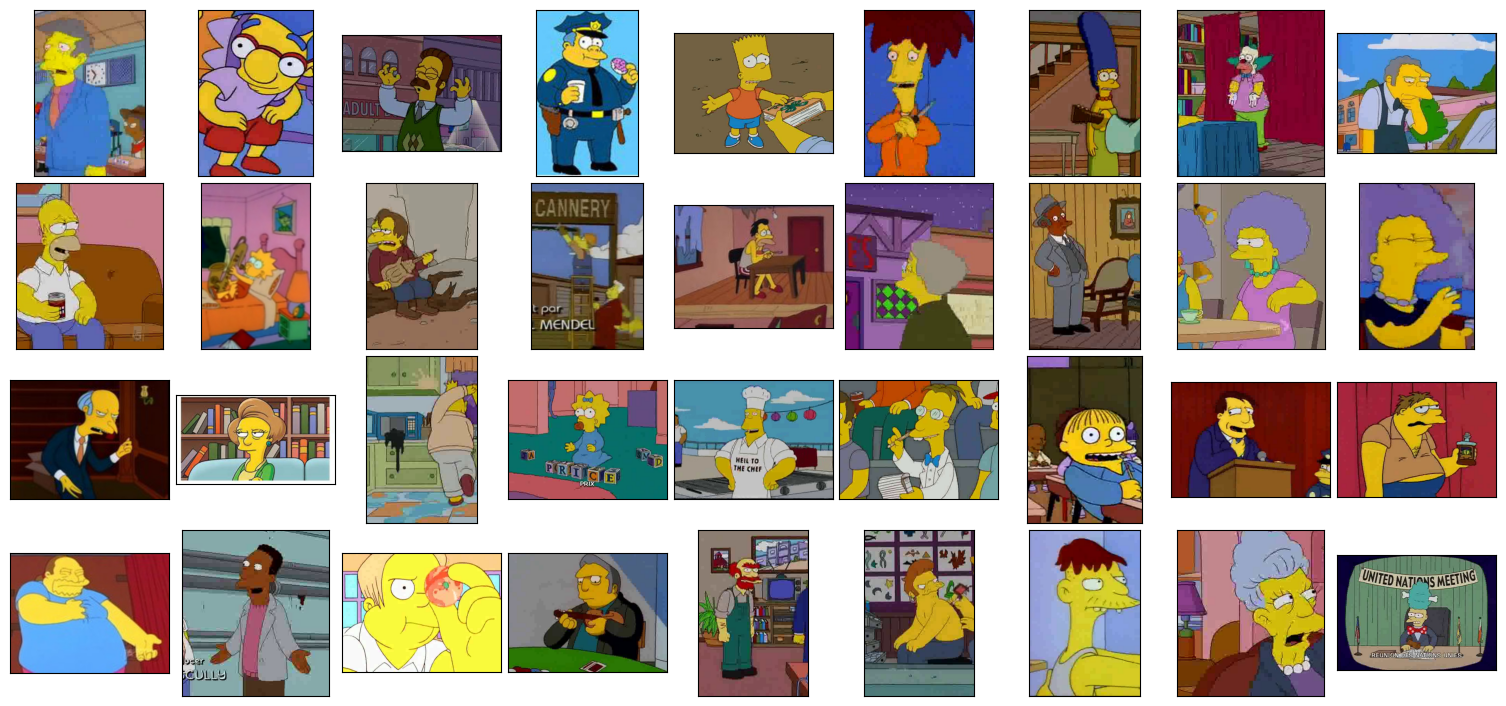

In [27]:
# Create a DataFrame with one Label of each category
df_unique = df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display 36 picture of the dataset
fig, axes = plt.subplots(nrows=4, ncols=9, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
#     ax.set_title(df_unique.Label[i])
plt.tight_layout(pad=0.5)
plt.show()

### Load the Images with a generator

In [6]:
# Separate in train and test data
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=SEED, stratify=df['Label'])

In [7]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [8]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 6371 validated image filenames belonging to 36 classes.
Found 1592 validated image filenames belonging to 36 classes.
Found 1991 validated image filenames belonging to 36 classes.


# Побудувати i навчити базову згорткову модель з одним згортковим шаром.

In [9]:
num_classes = len(train_images.class_indices)
print("Total classes:", num_classes)

Total classes: 36


In [12]:
class ConvolutionalModel(tf.keras.Model):
    def __init__(self, num_classes):
        super(ConvolutionalModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')
        self.maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(units=64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(units=num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense2(x)
    
model = ConvolutionalModel(num_classes=num_classes)

In [22]:
# Створення об'єкту TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Імпортування необхідного модуля
checkpoint_path = "checkpoints/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_freq='epoch',
                                                         verbose=1)


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, epochs=2, batch_size=32, validation_data=(test_images), 
          callbacks=[tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=1,
                            restore_best_weights=True
                        ),tensorboard_callback,  # Додано звіт TensorBoard
                    checkpoint_callback]) 

Epoch 1/2
838/838 [==============================] - ETA: 0s - loss: 3.2707 - accuracy: 0.1476
Epoch 1: saving model to checkpoints/cp.ckpt
838/838 [==============================] - 246s 292ms/step - loss: 3.2707 - accuracy: 0.1476 - val_loss: 2.6441 - val_accuracy: 0.2159
Epoch 2/2
838/838 [==============================] - ETA: 0s - loss: 2.3791 - accuracy: 0.2860
Epoch 2: saving model to checkpoints/cp.ckpt
838/838 [==============================] - 130s 155ms/step - loss: 2.3791 - accuracy: 0.2860 - val_loss: 2.2487 - val_accuracy: 0.3246


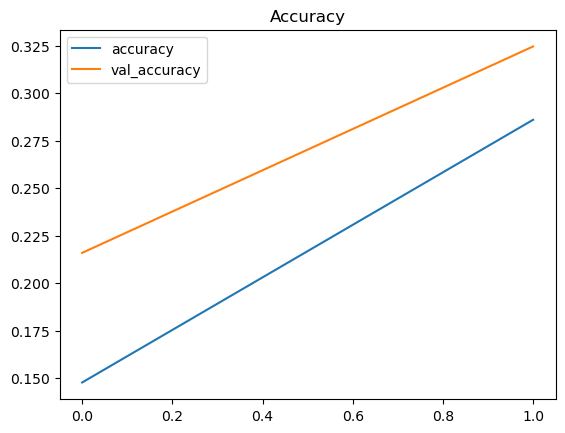

In [23]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

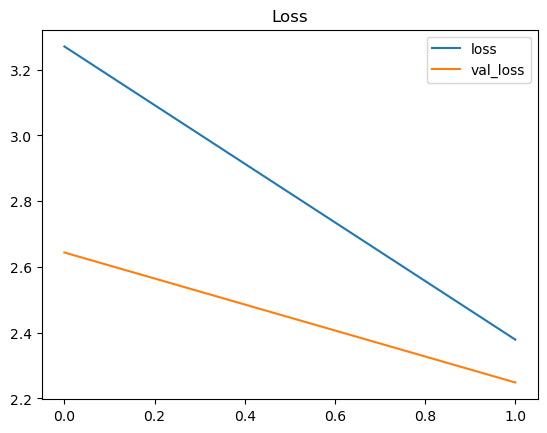

In [24]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [16]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

### Evaluation

In [25]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

262/262 [==============================] - 25s 97ms/step


In [26]:
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 32.46%


In [27]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.60      0.01      0.02       365
           agnes_skinner       1.00      0.00      0.00        17
  apu_nahasapeemapetilon       0.18      0.14      0.16       249
           barney_gumble       1.00      0.00      0.00        42
            bart_simpson       0.27      0.41      0.33       537
            carl_carlson       1.00      0.00      0.00        39
charles_montgomery_burns       0.23      0.21      0.21       477
            chief_wiggum       0.35      0.53      0.42       394
         cletus_spuckler       1.00      0.00      0.00        19
          comic_book_guy       0.20      0.01      0.01       188
               disco_stu       1.00      0.00      0.00         3
          edna_krabappel       1.00      0.00      0.00       183
                fat_tony       1.00      0.00      0.00        11
                     gil       1.00      0.00      0.00        11
    groun

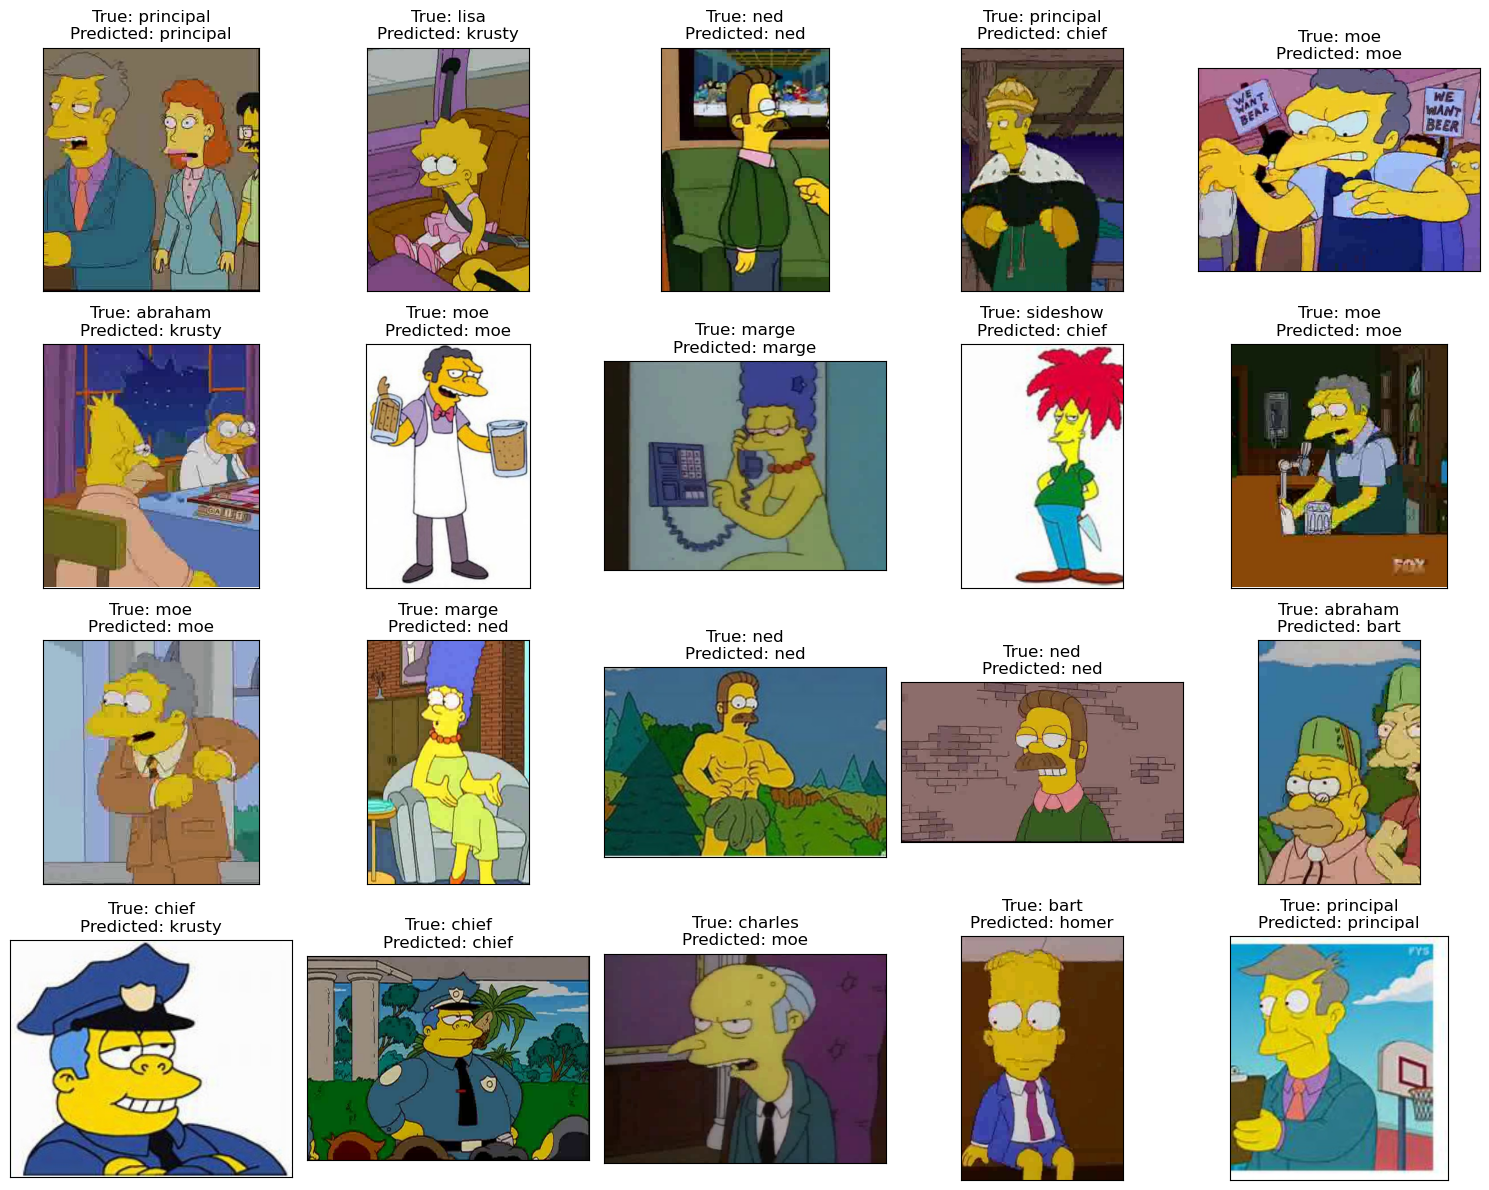

In [28]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}")
plt.tight_layout()
plt.show()

In [33]:
custom_dir = Path('../input/simpsons-data')
custom_filepaths = list(custom_dir.glob(r'**/*.jpeg'))

In [30]:
custom_labels = ['homer_simpson', 'lionel_hutz', 'abraham_grampa_simpson','homer_simpson', 'agnes_skinner', 'bart_simpson', 'homer_simpson', 'gil']

In [31]:
def predict_custom(custom_image, print_image=True):
    original_image = imread(custom_image)
    cropped_image = original_image
    shape = original_image.shape
    if shape[0] < shape[1]:
        margin = int((shape[1] - shape[0])/2)
        cropped_image = original_image[:, margin:-margin]
    if shape[0] > shape[1]:
        margin = int((shape[0] - shape[1])/2)
        cropped_image = original_image[margin:-margin]
    image = resize(cropped_image, (224, 224))
    if print_image:
        plt.imshow(image)
    prediction = model.predict(image[None, ...])
    
    prediction = np.argmax(prediction, axis=1)
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    prediction = [labels[k] for k in prediction]
    return prediction

1/1 [==============================] - 0s 20ms/step


['homer_simpson']

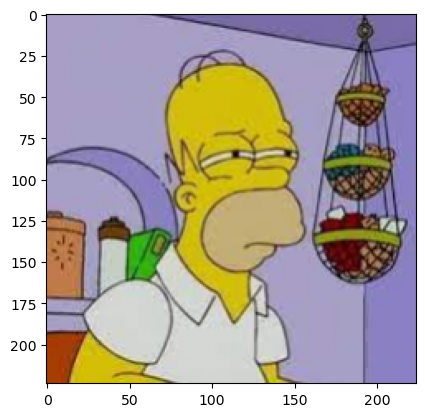

In [37]:
predict_custom(custom_filepaths[3])

1/1 [==============================] - 0s 19ms/step


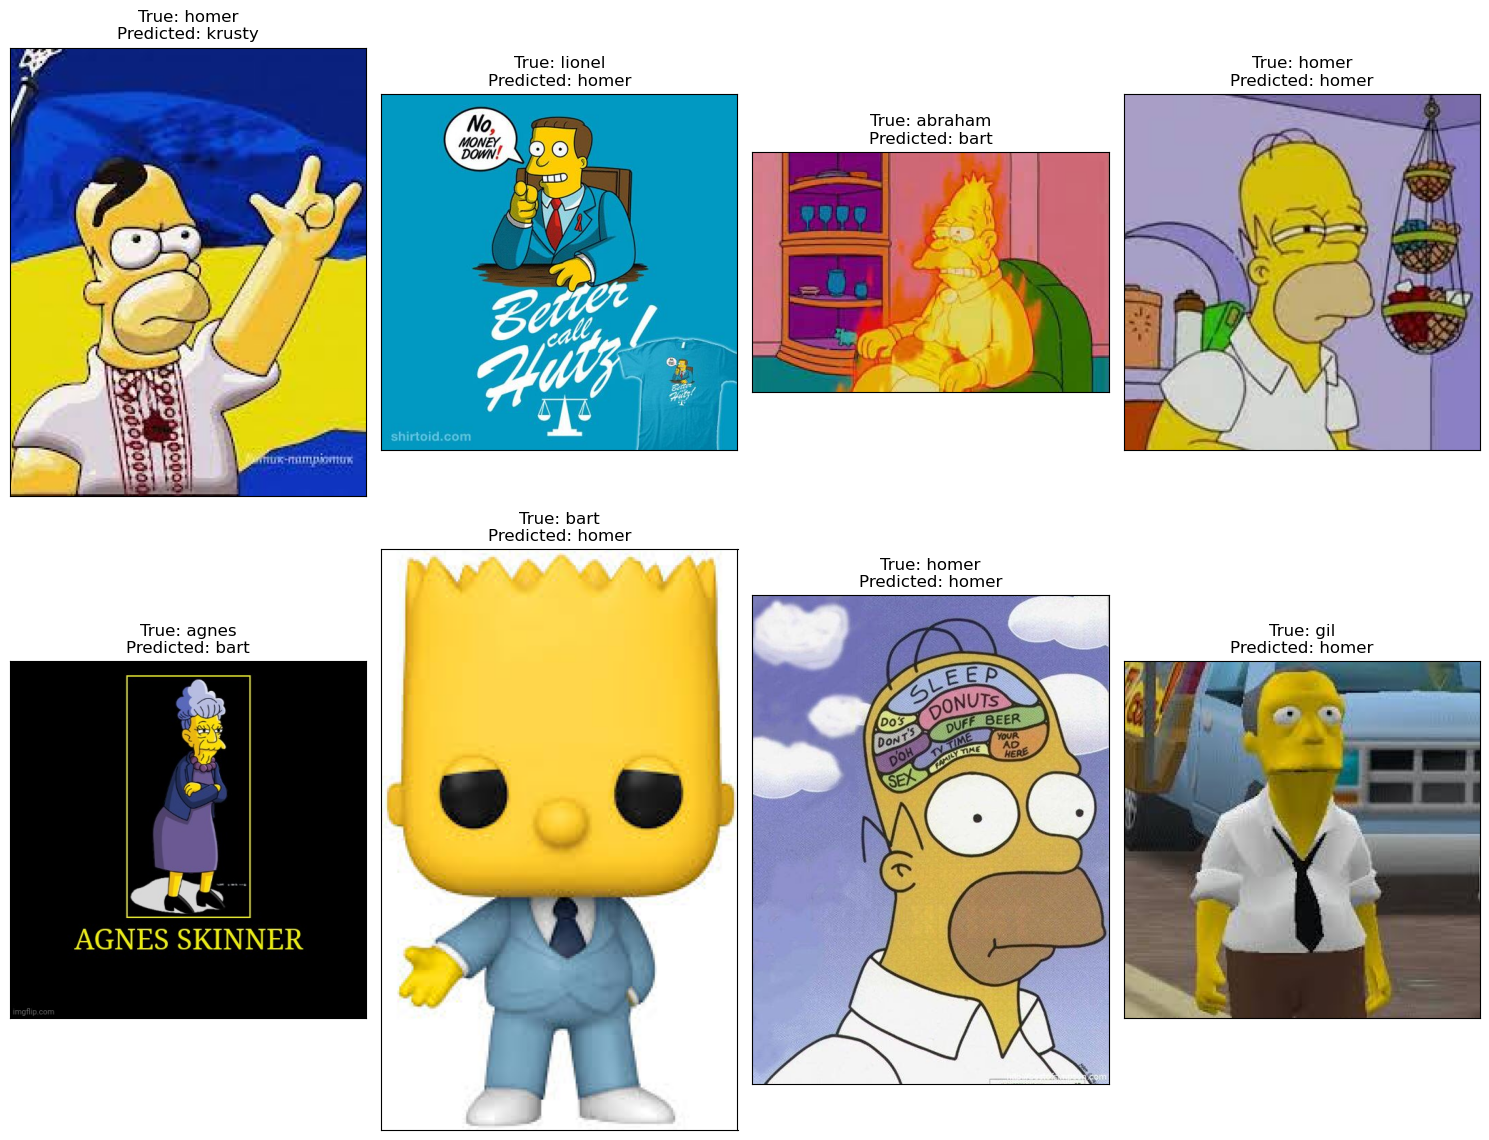

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(custom_filepaths[i]))
    ax.set_title(f"True: {custom_labels[i].split('_')[0]}\nPredicted: {predict_custom(custom_filepaths[i], print_image = False)[0].split('_')[0]}")
plt.tight_layout()
plt.show()

# Побудувати i навчити кiлька розширених згорткових моделей, якi включають шари дропауту i нормалiзацiї за мiнi-батчами.

### Спершу розглянемо модель без шарів дропауту та нормалізації за міні-батчами

In [13]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [39]:
# Створення об'єкту TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Імпортування необхідного модуля
checkpoint_path = "checkpoints/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_freq='epoch',
                                                         verbose=1)



model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, epochs=3, batch_size=32, validation_data=(test_images), 
          callbacks=[tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=1,
                            restore_best_weights=True
                        ),tensorboard_callback,  # Додано звіт TensorBoard
                    checkpoint_callback]) 

Epoch 1/3
838/838 [==============================] - ETA: 0s - loss: 3.4843 - accuracy: 0.1214
Epoch 1: saving model to checkpoints/cp.ckpt
838/838 [==============================] - 113s 133ms/step - loss: 3.4843 - accuracy: 0.1214 - val_loss: 3.0221 - val_accuracy: 0.1143
Epoch 2/3
838/838 [==============================] - ETA: 0s - loss: 2.9164 - accuracy: 0.1509
Epoch 2: saving model to checkpoints/cp.ckpt
838/838 [==============================] - 110s 131ms/step - loss: 2.9164 - accuracy: 0.1509 - val_loss: 2.8900 - val_accuracy: 0.1603
Epoch 3/3
838/838 [==============================] - ETA: 0s - loss: 2.7510 - accuracy: 0.1876
Epoch 3: saving model to checkpoints/cp.ckpt
838/838 [==============================] - 106s 126ms/step - loss: 2.7510 - accuracy: 0.1876 - val_loss: 2.7110 - val_accuracy: 0.2038


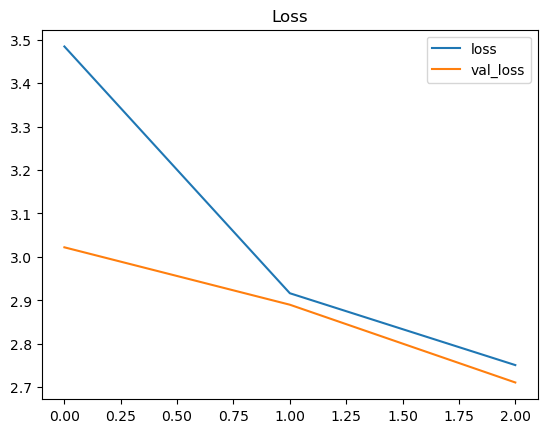

In [40]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

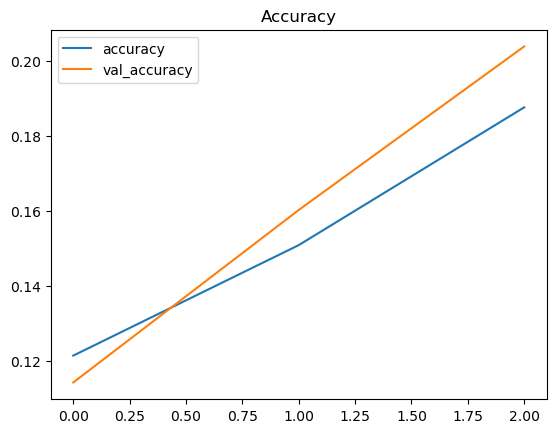

In [41]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [42]:
loss, accuracy = model.evaluate(test_images)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

262/262 [==============================] - 22s 85ms/step - loss: 2.7110 - accuracy: 0.2038
Test Loss: 2.710979461669922
Test Accuracy: 0.20384523272514343


In [46]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

In [47]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

262/262 [==============================] - 29s 112ms/step


In [48]:
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 20.38%


In [49]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       1.00      0.00      0.00       365
           agnes_skinner       1.00      0.00      0.00        17
  apu_nahasapeemapetilon       1.00      0.00      0.00       249
           barney_gumble       1.00      0.00      0.00        42
            bart_simpson       1.00      0.00      0.00       537
            carl_carlson       1.00      0.00      0.00        39
charles_montgomery_burns       1.00      0.00      0.00       477
            chief_wiggum       1.00      0.00      0.00       394
         cletus_spuckler       1.00      0.00      0.00        19
          comic_book_guy       1.00      0.00      0.00       188
               disco_stu       1.00      0.00      0.00         3
          edna_krabappel       1.00      0.00      0.00       183
                fat_tony       1.00      0.00      0.00        11
                     gil       1.00      0.00      0.00        11
    groun

In [36]:
next(train_images)[0][0].shape

(224, 224, 3)

### Тепер добавимо нормалiзацiю за мiнi-батчами та шари дропауту

In [45]:
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Dense (fully connected) layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(36, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_2 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_3 (Batc  (None, 109, 109, 64)     256       
 hNormalization)                                                 
                                                      

In [46]:
# Створення об'єкту TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Імпортування необхідного модуля
checkpoint_path = "checkpoints/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_freq='epoch',
                                                         verbose=1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, epochs=3, batch_size=8, validation_data=(val_images), 
          callbacks=[tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=1,
                            restore_best_weights=True
                        ),tensorboard_callback,
                    checkpoint_callback]) 


Epoch 1/3
200/200 [==============================] - ETA: 0s - loss: 6.9394 - accuracy: 0.0754
Epoch 1: saving model to checkpoints/cp.ckpt
200/200 [==============================] - 34s 154ms/step - loss: 6.9394 - accuracy: 0.0754 - val_loss: 3.4049 - val_accuracy: 0.0565
Epoch 2/3
200/200 [==============================] - ETA: 0s - loss: 3.4529 - accuracy: 0.1004
Epoch 2: saving model to checkpoints/cp.ckpt
200/200 [==============================] - 29s 147ms/step - loss: 3.4529 - accuracy: 0.1004 - val_loss: 3.2912 - val_accuracy: 0.1010
Epoch 3/3
199/200 [============================>.] - ETA: 0s - loss: 3.3302 - accuracy: 0.1000
Epoch 3: saving model to checkpoints/cp.ckpt
200/200 [==============================] - 28s 142ms/step - loss: 3.3302 - accuracy: 0.1001 - val_loss: 3.2207 - val_accuracy: 0.1092


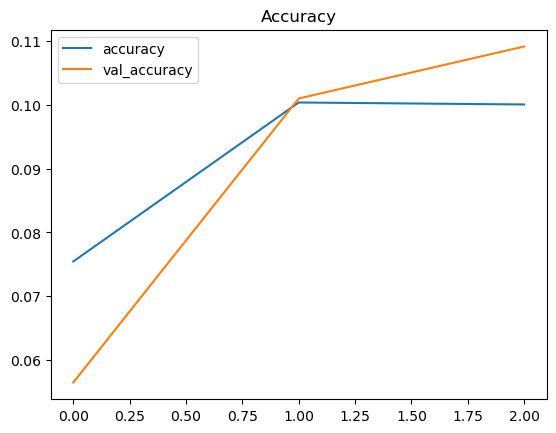

In [47]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

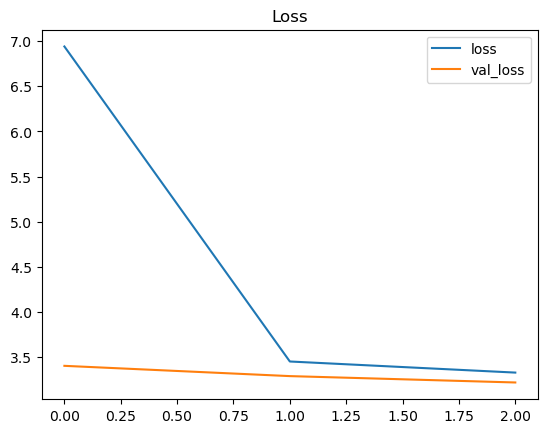

In [49]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [65]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Дослiдити чи впливає на результат змiна параметрiв padding i strides згорткового шару, а також розмiрнiсть ядра (kernel) згортки.

Зміна параметрів, таких як padding, strides та розмір ядра (kernel), може вплинути на результат згорткового шару. 

1. Padding (заповнення): Визначає, як обробляти краї зображення під час згортки. Параметр padding може мати значення 'valid' або 'same'. 'valid' означає, що заповнення не використовується, тому вихідний розмір зменшується. 'same' означає, що зображення доповнюється нулями, щоб зберегти однаковий розмір виходу. Зміна padding може вплинути на розмір виходу згорткового шару і, отже, на подальші шари моделі.

2. Strides (кроки): Визначає кроки, з якими фільтри пересуваються під час згортки. Збільшення значення strides зменшує вихідний розмір, оскільки фільтри переміщуються з більшим кроком. Зменшення значення strides збільшує розмір виходу, оскільки фільтри пересуваються з меншим кроком. Зміна strides може вплинути на роздільну здатність моделі та її здатність виявляти деталі.

3. Розмір ядра (kernel): Визначає розмір фільтра, який застосовується під час згортки. Збільшення розміру ядра розширює область огляду і може допомогти виявити більші шаблони або структури в зображенні. Зменшення розміру ядра зменшує область огляду і дозволяє моделі фокусуватися на менших деталях.

Перевіримо це на практиці

###  Змiна параметрiв padding i strides. Зміна розмiрності ядра (kernel) згортки

In [50]:
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Dense (fully connected) layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(36, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_5 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 112, 112, 64)      51264     
                                                                 
 batch_normalization_6 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                      

In [52]:
# Створення об'єкту TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Імпортування необхідного модуля
checkpoint_path = "checkpoints/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_freq='epoch',
                                                         verbose=1)



# model = ConvolutionalModel(num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, epochs=5, batch_size=16, validation_data=(test_images), 
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=1,
                            restore_best_weights=True
                        ),tensorboard_callback,  # Додано звіт TensorBoard
                    checkpoint_callback]) 

Epoch 1/5
200/200 [==============================] - ETA: 0s - loss: 7.7439 - accuracy: 0.0643
Epoch 1: saving model to checkpoints/cp.ckpt
200/200 [==============================] - 46s 208ms/step - loss: 7.7439 - accuracy: 0.0643 - val_loss: 3.4624 - val_accuracy: 0.0723
Epoch 2/5
200/200 [==============================] - ETA: 0s - loss: 3.5799 - accuracy: 0.0769
Epoch 2: saving model to checkpoints/cp.ckpt
200/200 [==============================] - 32s 158ms/step - loss: 3.5799 - accuracy: 0.0769 - val_loss: 3.3549 - val_accuracy: 0.1064
Epoch 3/5
200/200 [==============================] - ETA: 0s - loss: 3.3807 - accuracy: 0.0886
Epoch 3: saving model to checkpoints/cp.ckpt
200/200 [==============================] - 31s 153ms/step - loss: 3.3807 - accuracy: 0.0886 - val_loss: 3.2712 - val_accuracy: 0.1034
Epoch 4/5
200/200 [==============================] - ETA: 0s - loss: 3.2577 - accuracy: 0.0958
Epoch 4: saving model to checkpoints/cp.ckpt
200/200 [=============================

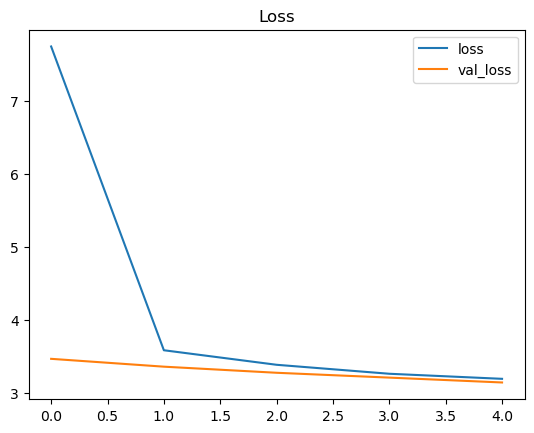

In [53]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

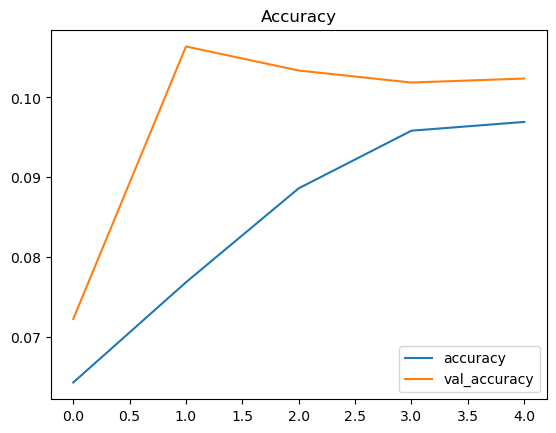

In [54]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [55]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

63/63 [==============================] - 6s 86ms/step


In [56]:
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 10.24%


In [57]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       1.00      0.00      0.00        87
           agnes_skinner       1.00      0.00      0.00         3
  apu_nahasapeemapetilon       1.00      0.00      0.00        57
           barney_gumble       1.00      0.00      0.00        12
            bart_simpson       1.00      0.00      0.00       139
            carl_carlson       1.00      0.00      0.00         9
charles_montgomery_burns       1.00      0.00      0.00       118
            chief_wiggum       1.00      0.00      0.00        98
         cletus_spuckler       1.00      0.00      0.00         4
          comic_book_guy       1.00      0.00      0.00        44
          edna_krabappel       1.00      0.00      0.00        43
                fat_tony       1.00      0.00      0.00         3
    groundskeeper_willie       1.00      0.00      0.00        11
           homer_simpson       0.10      1.00      0.19       205
         

# Зробити висновки щодо якостi навчання мережi:

1) З використанням та без використання Dropout та Batch Normalization:
       
       - Dropout та Batch Normalization є техніками регуляризації, які допомагають запобігти перенавчанню та покращують узагальнення моделі.
       
       - Навчання мережі без Dropout та Batch Normalization може призвести до вищої точності на тренувальних даних, але це може спричинити перенавчання, особливо якщо набір даних невеликий.
       
       - Включення Dropout та Batch Normalization ймовірно призведе до кращої здатності моделі до узагальнення та зробить її більш стійкою до варіацій в даних.

2) Різні значення padding та strides у згортковому шарі:
       
       - Padding визначає кількість додавання нулів до вхідного зображення перед застосуванням згортки. Це впливає на просторові розміри отриманих карт ознак.
       
       - Strides визначає крок, з яким згорткове ядро рухається по вхідному зображенню.
       
       - Зміна padding та strides може вплинути на розміри карт ознак та область, яку охоплює мережа.
       
       - Важливо знайти баланс між збереженням просторової інформації та зменшенням розмірності, оскільки це може вплинути на ефективність моделі.

3) Різні розміри ядра у згортковому шарі:
       
       - Розмір ядра визначає зону сприйняття кожного згорткового фільтра.
       
       - Менші розміри ядра захоплюють локальні ознаки, тоді як більші розміри ядра захоплюють більш глобальні ознаки.
       
       - Вибір відповідного розміру ядра залежить від складності та масштабу ознак, присутніх у зображеннях.
       
       - Використання різних розмірів ядра може призвести до варіацій у здатності моделі до виділення відповідних ознак та вивчення дискримінативних представлень.


# Побудувати ще одну модель на базi попередньо навченої VGG16, Inception, Exception чи iншої (на вибiр), використовуючи технологiю передачi знань (transfer learning).

### VGG16

In [11]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
vgg16.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [12]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [28]:
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(36, activation='softmax'))

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 36)               

In [30]:
# Створення об'єкту TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Імпортування необхідного модуля
checkpoint_path = "checkpoints/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_freq='epoch',
                                                         verbose=1)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=1,  restore_best_weights=True)

history = model.fit(train_images, epochs=10, batch_size=8, validation_data=(test_images)
          , callbacks=[es, tensorboard_callback, checkpoint_callback])

Epoch 1/10
200/200 [==============================] - ETA: 0s - loss: 3.3434 - accuracy: 0.0917
Epoch 1: saving model to checkpoints/cp.ckpt
200/200 [==============================] - 44s 214ms/step - loss: 3.3434 - accuracy: 0.0917 - val_loss: 2.9333 - val_accuracy: 0.1763
Epoch 2/10
200/200 [==============================] - ETA: 0s - loss: 3.0212 - accuracy: 0.1295
Epoch 2: saving model to checkpoints/cp.ckpt
200/200 [==============================] - 42s 208ms/step - loss: 3.0212 - accuracy: 0.1295 - val_loss: 2.7721 - val_accuracy: 0.2567
Epoch 3/10
200/200 [==============================] - ETA: 0s - loss: 2.8406 - accuracy: 0.1639
Epoch 3: saving model to checkpoints/cp.ckpt
200/200 [==============================] - 42s 210ms/step - loss: 2.8406 - accuracy: 0.1639 - val_loss: 2.5540 - val_accuracy: 0.2873
Epoch 4/10
200/200 [==============================] - ETA: 0s - loss: 2.7094 - accuracy: 0.1788
Epoch 4: saving model to checkpoints/cp.ckpt
200/200 [=========================

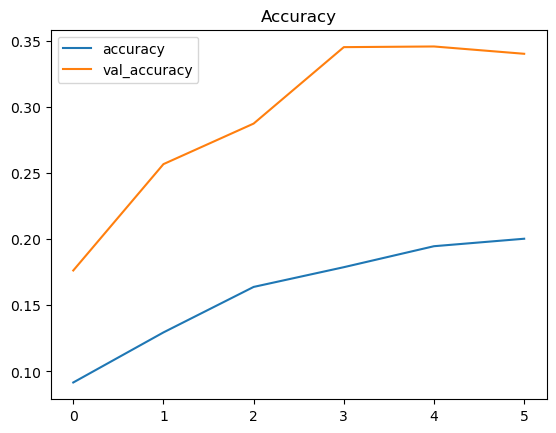

In [31]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

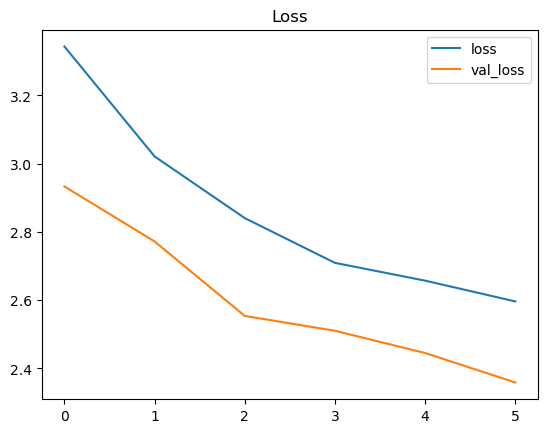

In [32]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [33]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

63/63 [==============================] - 8s 132ms/step


In [34]:
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 34.56%


In [35]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.52      0.49      0.51        90
           agnes_skinner       1.00      0.00      0.00         4
  apu_nahasapeemapetilon       1.00      0.00      0.00        63
           barney_gumble       1.00      0.00      0.00        10
            bart_simpson       0.88      0.34      0.49       128
            carl_carlson       1.00      0.00      0.00        11
charles_montgomery_burns       1.00      0.00      0.00       110
            chief_wiggum       1.00      0.00      0.00        94
         cletus_spuckler       1.00      0.00      0.00         6
          comic_book_guy       1.00      0.00      0.00        43
          edna_krabappel       1.00      0.00      0.00        45
                fat_tony       1.00      0.00      0.00         3
    groundskeeper_willie       1.00      0.00      0.00        11
           homer_simpson       0.29      0.87      0.43       219
         

### Inception v3

In [41]:
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))
inception.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


In [42]:
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [43]:
model3 = Sequential()
model3.add(inception)
model3.add(Flatten())
model3.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model3.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model3.add(Dense(36, activation='softmax'))

In [ ]:
# Створення об'єкту TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Імпортування необхідного модуля
checkpoint_path = "checkpoints/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_freq='epoch',
                                                         verbose=1)


model3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=1,  restore_best_weights=True)

history = model3.fit(train_images, epochs=10, batch_size=8, validation_data=(test_images)
          , callbacks=[es, tensorboard_callback, checkpoint_callback])

Epoch 1/10
200/200 [==============================] - ETA: 0s - loss: 1.8362 - accuracy: 0.5131

In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

In [ ]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

#  Висновки

Побудувано та навчено базову згорткову модель з одним згортковим шаром. Ця модель може бути використана для простих завдань класифікації зображень. Побудовано та навчено кілька розширених згорткових моделей, які включають шари дропауту і нормалізації за міні-батчами. Проведено дослідження щодо впливу параметрів padding і strides згорткового шару, а також розмірності ядра згортки на результат. Зміна цих параметрів може впливати на швидкість навчання, точність та ефективність моделі.  Побудовано графіки зміни функції втрат і точності на тренувальній і перевірочній множинах по мірі навчання моделей. Побудовано моделі на базi попередньо навчених VGG16 та Inception, використовуючи технологiю передачi знань (transfer learning)

# 